In [1]:
#!/usr/bin/env python
# coding: utf-8

import os
import ee
import io
import tqdm
import json
import fiona
import datetime
import requests
import urllib.request

import numpy as np
import xarray as xr
import pandas as pd
import rsfuncs as rs
import rasterio as rio
import geopandas as gp
import multiprocessing as mp

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from tqdm import tqdm
from affine import Affine
from datetime import timedelta
from rasterio import features, mask
from climata.usgs import DailyValueIO
from pandas.tseries.offsets import MonthEnd
from dateutil.relativedelta import relativedelta

ee.Initialize()


%load_ext autoreload
%autoreload 2

In [2]:
def get_snodas_swe(shppath,startdate,enddate, data_dir ="/Users/aakash/Desktop/SatDat/GRACE/SNODAS_GRACE_processed/" ):
    '''
    Given a path to a shapefile, compute the monthly SWE
    Input: (str) - path to shapefile
    Output: (pd.DataFrame) - monthly SWE 
    '''
    # Datetime the start/end
    start = datetime.datetime.strptime(startdate, "%Y-%m-%d")
    end = datetime.datetime.strptime(enddate, "%Y-%m-%d")
    dt_idx = pd.date_range(start,end, freq='D')
    
    # Find SWE files
    files = [os.path.join(data_dir,x) for x in os.listdir(data_dir) if x.endswith(".tif")]
    files.sort()

    # Read shapefile
    with fiona.open(shppath, "r") as shapefile:
        area_geom = [feature["geometry"] for feature in shapefile]

    # Read the files, mask nans, clip to area, extract dates
    imdict = {}

    for i in tqdm(files[:]):
        date = datetime.datetime.strptime(i[-16:-8],'%Y%m%d')# Get the date 
        datestr = date.strftime('%Y%m%d') # Format date
        if date >= start and date <= end:
            src = rio.open(i) # Read file
            src2 = rio.mask.mask(src, area_geom, crop=True) # Clip to shp 
            arr = src2[0].astype(float) # read as array
            arr = arr.reshape(arr.shape[1], arr.shape[2]) # Reshape bc rasterio has a different dim ordering 
            arr[arr < 0 ] = np.nan # Mask nodata vals 
            imdict[datestr] = arr/1000 # divide by scale factor to get SWE in m 
    
    all_dates = {}

    for i in dt_idx:
        date = i.strftime("%Y%m%d") 

        if date in imdict.keys():
            im = imdict[date]
        else:
            im = np.zeros_like(list(imdict.values())[0])
            im[im==0] = np.nan
        all_dates[date] = im
    
    return all_dates
            
def get_res_inflow(stid, startdate, enddate):
    '''
    Fetch the daily reservoir inflow for a CDEC reservoir ID
    Input: stid (str) - 3 letter station id (ex: ISB)
    Output: Sres - (pd.DataFrame) - the full monthly flow (km^3 / mon)
    '''
    # Download Storage (SensorNums = 65) data by query str:
    start = datetime.datetime.strptime(startdate, "%Y-%m-%d")
    end = datetime.datetime.strptime(enddate, "%Y-%m-%d")
    dt_idx = pd.date_range(start,end, freq='D')
    url = '''https://cdec.water.ca.gov/dynamicapp/req/CSVDataServlet?Stations={}&SensorNums=76&dur_code=D&Start=2000-01-01&End=2020-01-01'''.format(stid)
    print(url)
    urlData = requests.get(url).content
    df = pd.read_csv(io.StringIO(urlData.decode('utf-8')))
    inflow = pd.to_numeric(df.VALUE, errors='coerce')
    indf = pd.DataFrame(zip(dt_idx,inflow* 0.0283168), columns = ['date',"q_cms"]) # cfs --> CMS 
    
    return rs.col_to_dt(indf)


def df_shifted(df, target=None, lag=0):
    if not lag and not target:
        return df       
    new = {}
    for c in df.columns:
        if c == target:
            new[c] = df[target]
        else:
            new[c] = df[c].shift(periods=lag)
    return  pd.DataFrame(data=new)

In [3]:
# Read catchments, reservoirs
gdf = gp.read_file("../shape/sierra_catchments.shp")

# Load rs data
data = rs.load_data()

In [29]:
startdate = '2003-09-30'
enddate = '2019-10-01'
dt_idx = pd.date_range(startdate,enddate, freq='D')

0
************************************************************
ENG YUBA R
https://cdec.water.ca.gov/dynamicapp/req/CSVDataServlet?Stations=ENG&SensorNums=76&dur_code=D&Start=2000-01-01&End=2020-01-01


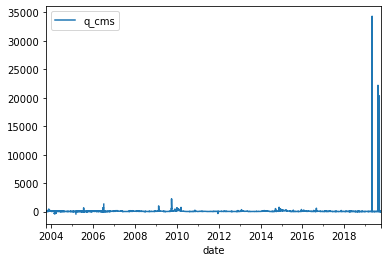

100%|██████████| 6210/6210 [09:17<00:00, 11.14it/s]


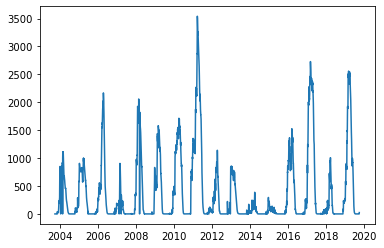

Running Xcorr...
wrote ../rasters/ENG_lag.tif


<ipython-input-31-551c937acae8>:88: RuntimeWarning: Mean of empty slice
  im2 = ax2.imshow(np.nanmean(swestack, axis = 2))


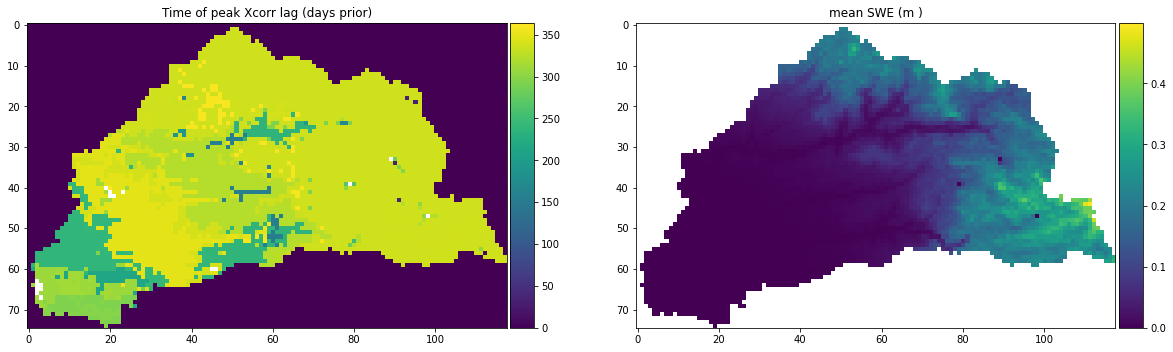

1
************************************************************
PAR MOKELUMNE R
https://cdec.water.ca.gov/dynamicapp/req/CSVDataServlet?Stations=PAR&SensorNums=76&dur_code=D&Start=2000-01-01&End=2020-01-01


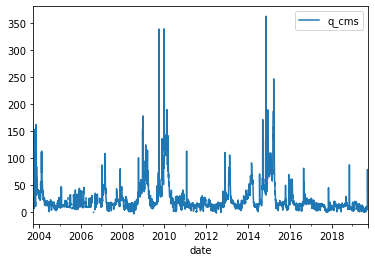

100%|██████████| 6210/6210 [07:25<00:00, 13.95it/s]


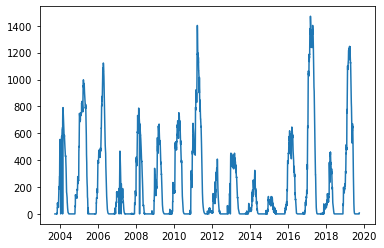

Running Xcorr...
wrote ../rasters/PAR_lag.tif


<ipython-input-31-551c937acae8>:88: RuntimeWarning: Mean of empty slice
  im2 = ax2.imshow(np.nanmean(swestack, axis = 2))


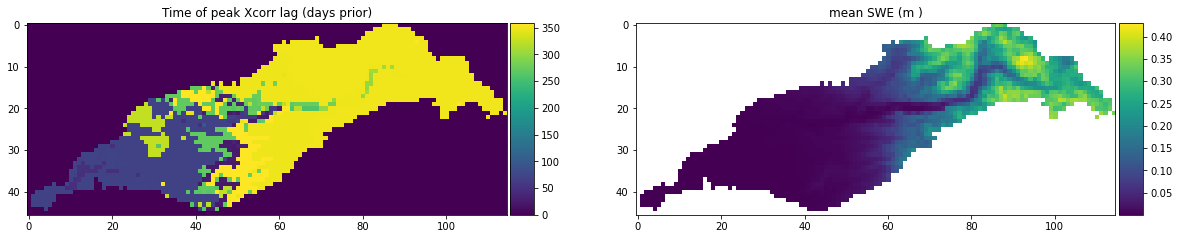

2
************************************************************
MIL SAN JOAQUIN R
https://cdec.water.ca.gov/dynamicapp/req/CSVDataServlet?Stations=MIL&SensorNums=76&dur_code=D&Start=2000-01-01&End=2020-01-01


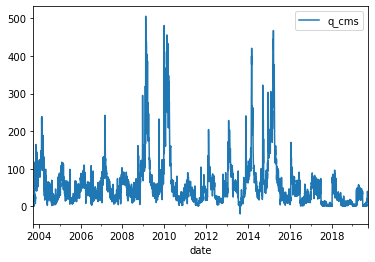

100%|██████████| 6210/6210 [08:30<00:00, 12.17it/s]


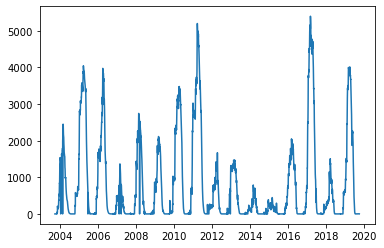

Running Xcorr...
wrote ../rasters/MIL_lag.tif


<ipython-input-31-551c937acae8>:88: RuntimeWarning: Mean of empty slice
  im2 = ax2.imshow(np.nanmean(swestack, axis = 2))


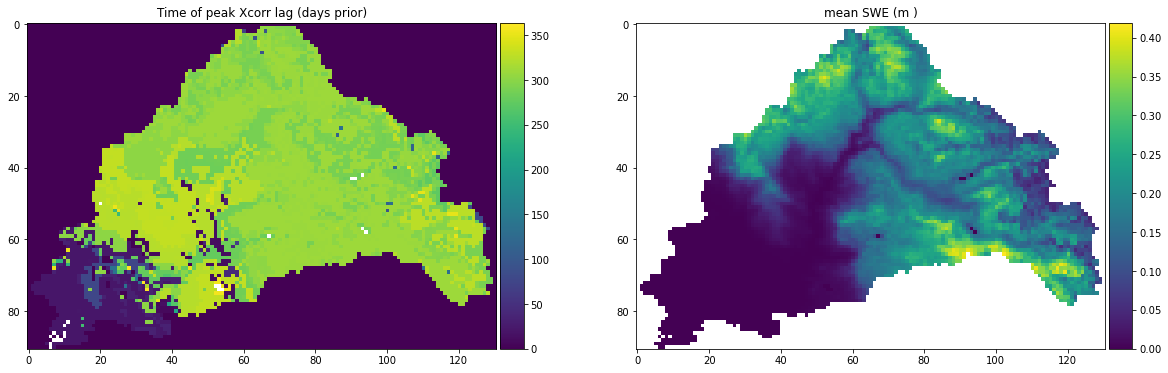

3
************************************************************
ISB KERN R
https://cdec.water.ca.gov/dynamicapp/req/CSVDataServlet?Stations=ISB&SensorNums=76&dur_code=D&Start=2000-01-01&End=2020-01-01


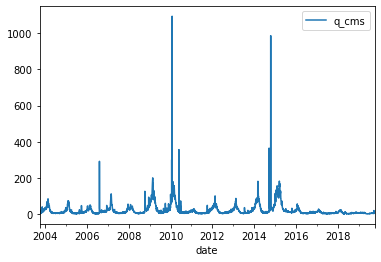

100%|██████████| 6210/6210 [15:38<00:00,  6.62it/s] 


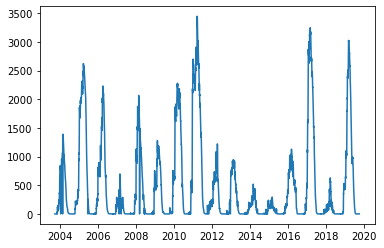

Running Xcorr...
wrote ../rasters/ISB_lag.tif


<ipython-input-31-551c937acae8>:88: RuntimeWarning: Mean of empty slice
  im2 = ax2.imshow(np.nanmean(swestack, axis = 2))


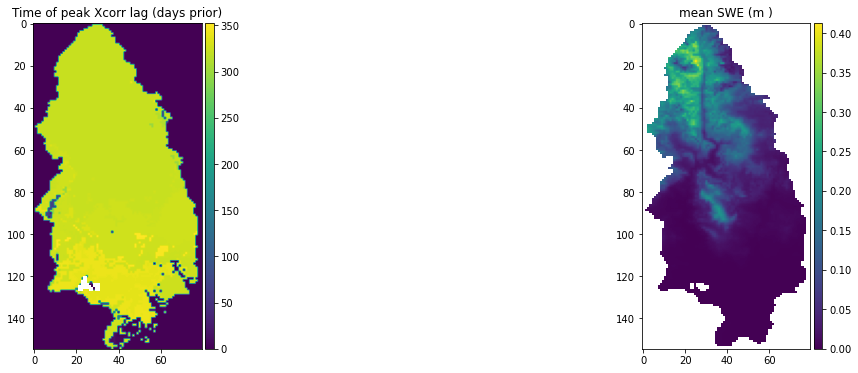

4
************************************************************
DNP TUOLUMNE R
https://cdec.water.ca.gov/dynamicapp/req/CSVDataServlet?Stations=DNP&SensorNums=76&dur_code=D&Start=2000-01-01&End=2020-01-01


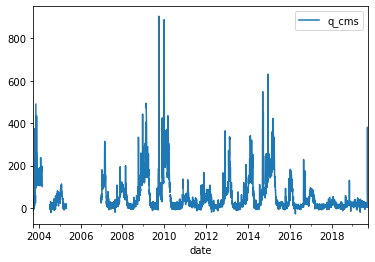

100%|██████████| 6210/6210 [08:33<00:00, 12.09it/s]


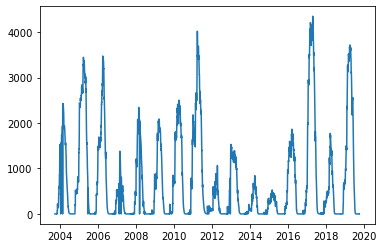

Running Xcorr...
wrote ../rasters/DNP_lag.tif


<ipython-input-31-551c937acae8>:88: RuntimeWarning: Mean of empty slice
  im2 = ax2.imshow(np.nanmean(swestack, axis = 2))


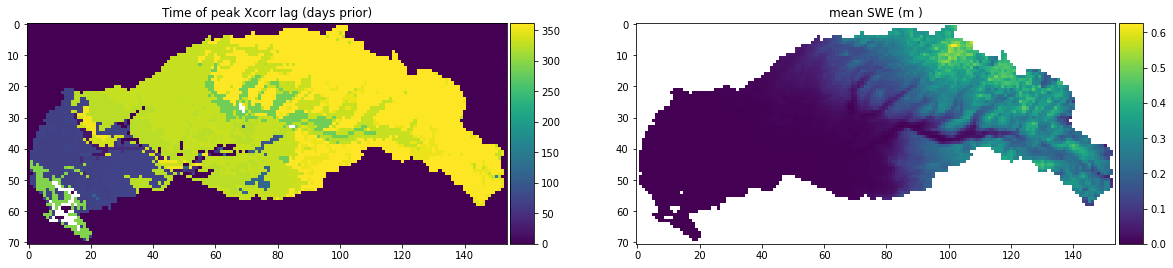

5
************************************************************
NML STANISLAUS R
https://cdec.water.ca.gov/dynamicapp/req/CSVDataServlet?Stations=NML&SensorNums=76&dur_code=D&Start=2000-01-01&End=2020-01-01


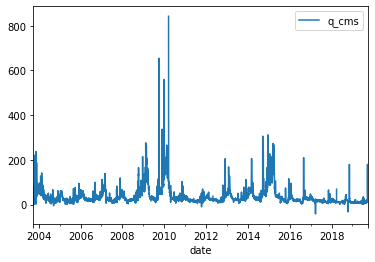

100%|██████████| 6210/6210 [07:52<00:00, 13.15it/s]


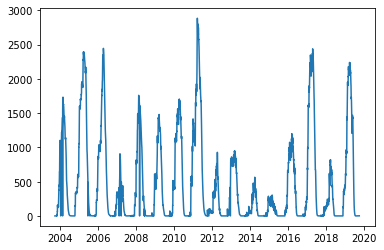

Running Xcorr...
wrote ../rasters/NML_lag.tif


<ipython-input-31-551c937acae8>:88: RuntimeWarning: Mean of empty slice
  im2 = ax2.imshow(np.nanmean(swestack, axis = 2))


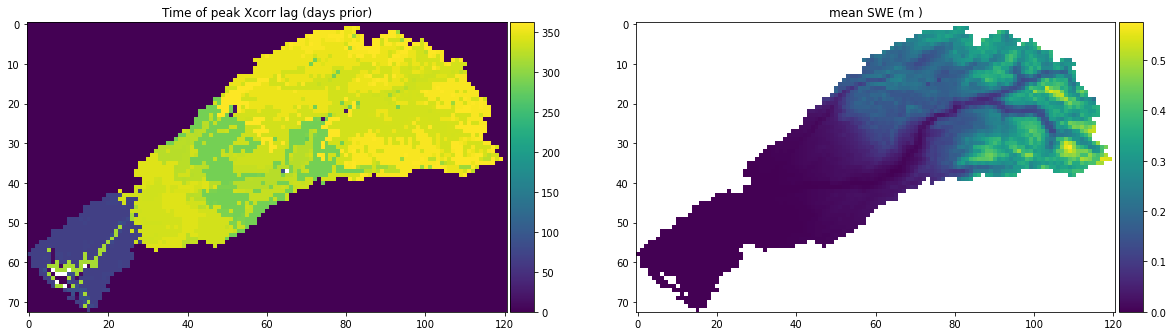

6
************************************************************
ORO FEATHER R
https://cdec.water.ca.gov/dynamicapp/req/CSVDataServlet?Stations=ORO&SensorNums=76&dur_code=D&Start=2000-01-01&End=2020-01-01


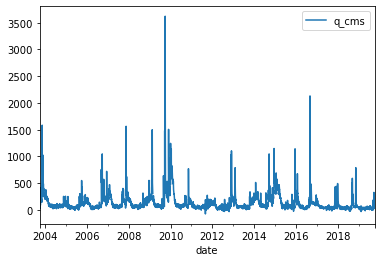

100%|██████████| 6210/6210 [11:40<00:00,  8.87it/s]


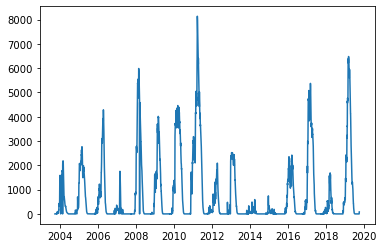

Running Xcorr...
wrote ../rasters/ORO_lag.tif


<ipython-input-31-551c937acae8>:88: RuntimeWarning: Mean of empty slice
  im2 = ax2.imshow(np.nanmean(swestack, axis = 2))


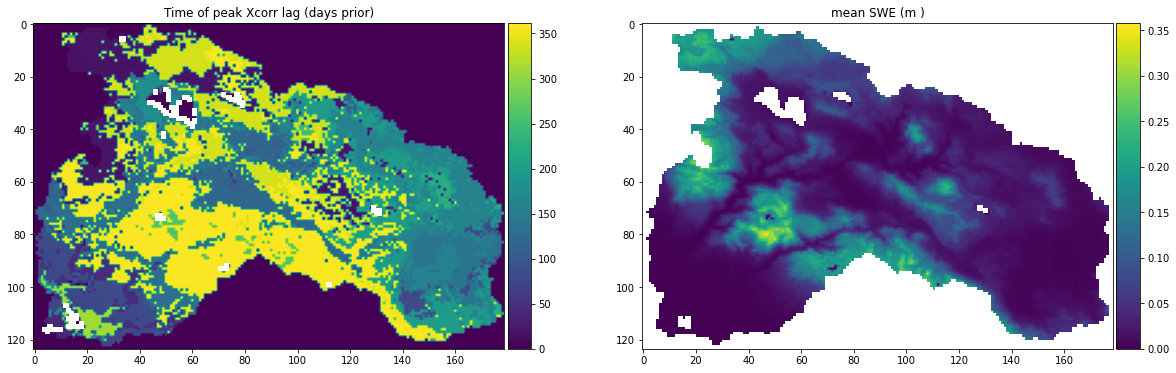

7
************************************************************
FOL AMERICAN R
https://cdec.water.ca.gov/dynamicapp/req/CSVDataServlet?Stations=FOL&SensorNums=76&dur_code=D&Start=2000-01-01&End=2020-01-01


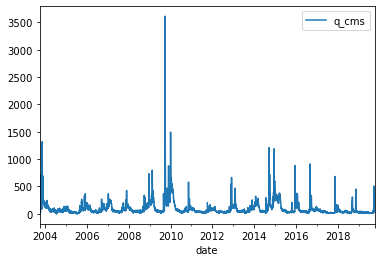

100%|██████████| 6210/6210 [10:56<00:00,  9.46it/s]


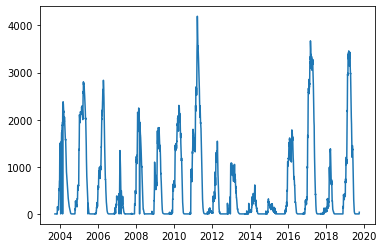

Running Xcorr...
wrote ../rasters/FOL_lag.tif


<ipython-input-31-551c937acae8>:88: RuntimeWarning: Mean of empty slice
  im2 = ax2.imshow(np.nanmean(swestack, axis = 2))


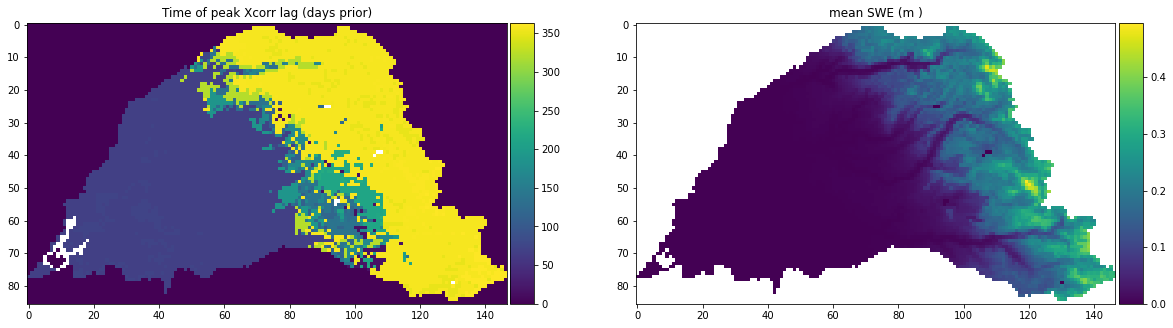

8
************************************************************
TRM KAWEAH R
https://cdec.water.ca.gov/dynamicapp/req/CSVDataServlet?Stations=TRM&SensorNums=76&dur_code=D&Start=2000-01-01&End=2020-01-01


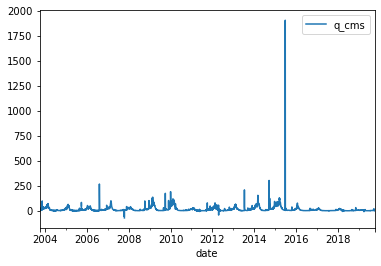

100%|██████████| 6210/6210 [07:34<00:00, 13.65it/s]


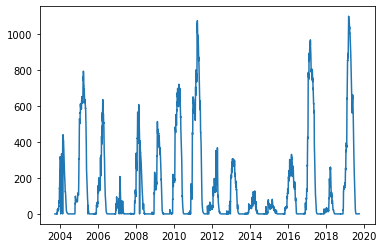

Running Xcorr...
wrote ../rasters/TRM_lag.tif


<ipython-input-31-551c937acae8>:88: RuntimeWarning: Mean of empty slice
  im2 = ax2.imshow(np.nanmean(swestack, axis = 2))


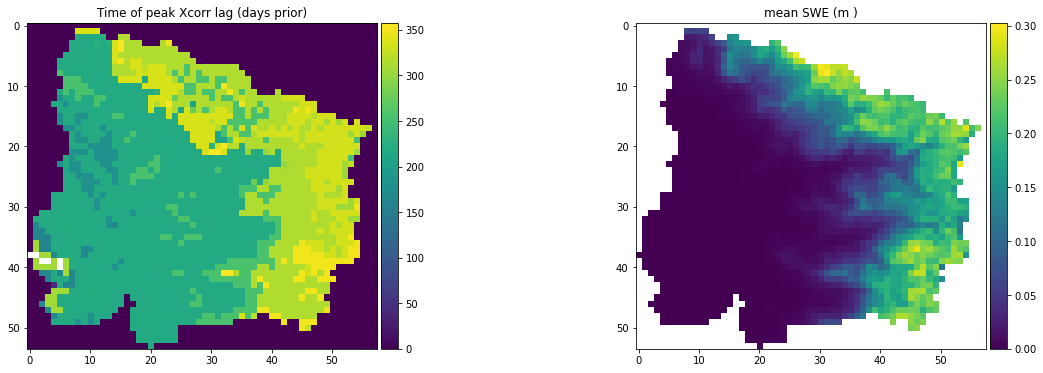

9
************************************************************
SCC TULE R
https://cdec.water.ca.gov/dynamicapp/req/CSVDataServlet?Stations=SCC&SensorNums=76&dur_code=D&Start=2000-01-01&End=2020-01-01


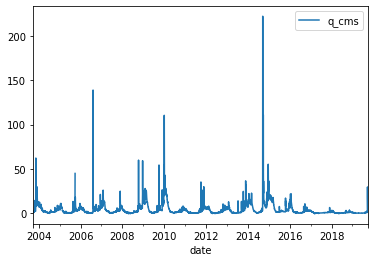

100%|██████████| 6210/6210 [05:27<00:00, 18.95it/s]


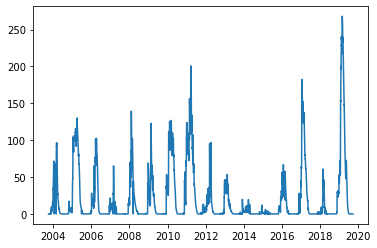

Running Xcorr...
wrote ../rasters/SCC_lag.tif


<ipython-input-31-551c937acae8>:88: RuntimeWarning: Mean of empty slice
  im2 = ax2.imshow(np.nanmean(swestack, axis = 2))


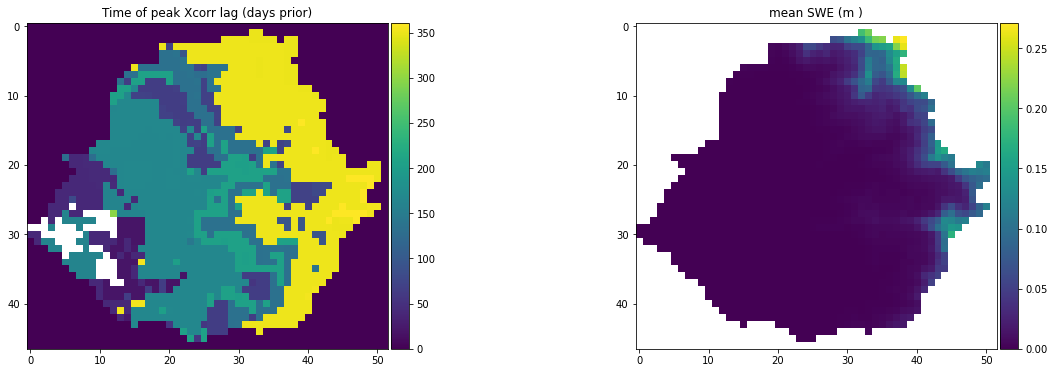

10
************************************************************
CFW BEAR R
https://cdec.water.ca.gov/dynamicapp/req/CSVDataServlet?Stations=CFW&SensorNums=76&dur_code=D&Start=2000-01-01&End=2020-01-01
no data for CFW
11
************************************************************
PNF KINGS R
https://cdec.water.ca.gov/dynamicapp/req/CSVDataServlet?Stations=PNF&SensorNums=76&dur_code=D&Start=2000-01-01&End=2020-01-01


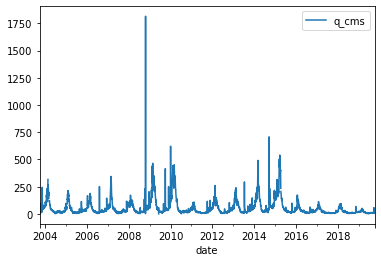

100%|██████████| 6210/6210 [09:13<00:00, 11.23it/s]


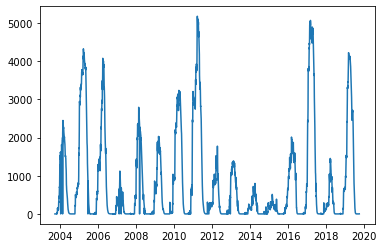

Running Xcorr...
wrote ../rasters/PNF_lag.tif


<ipython-input-31-551c937acae8>:88: RuntimeWarning: Mean of empty slice
  im2 = ax2.imshow(np.nanmean(swestack, axis = 2))


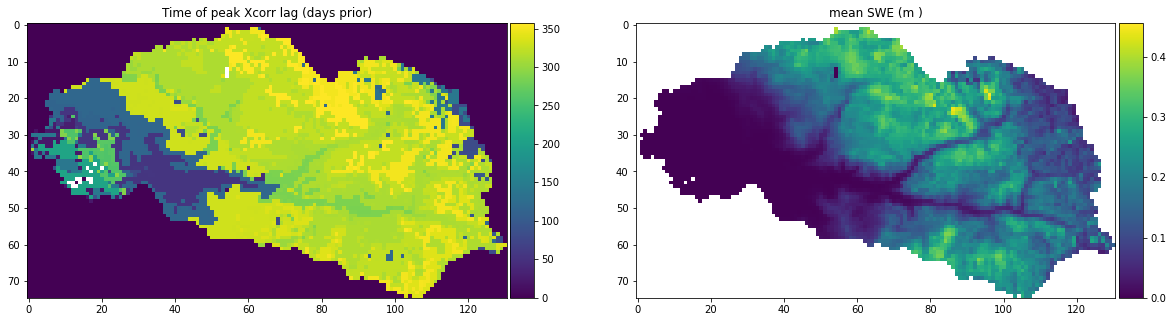

12
************************************************************
MCR MERCED R
https://cdec.water.ca.gov/dynamicapp/req/CSVDataServlet?Stations=MCR&SensorNums=76&dur_code=D&Start=2000-01-01&End=2020-01-01
no data for MCR
13
************************************************************
NHG CALAVERAS R
https://cdec.water.ca.gov/dynamicapp/req/CSVDataServlet?Stations=NHG&SensorNums=76&dur_code=D&Start=2000-01-01&End=2020-01-01


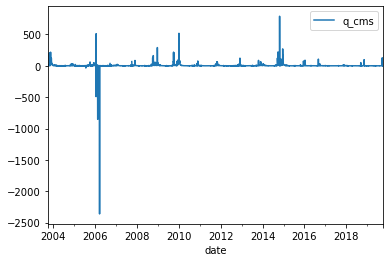

100%|██████████| 6210/6210 [05:56<00:00, 17.42it/s]


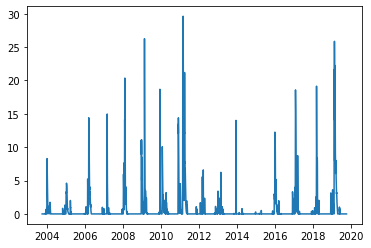

Running Xcorr...
wrote ../rasters/NHG_lag.tif


<ipython-input-31-551c937acae8>:88: RuntimeWarning: Mean of empty slice
  im2 = ax2.imshow(np.nanmean(swestack, axis = 2))


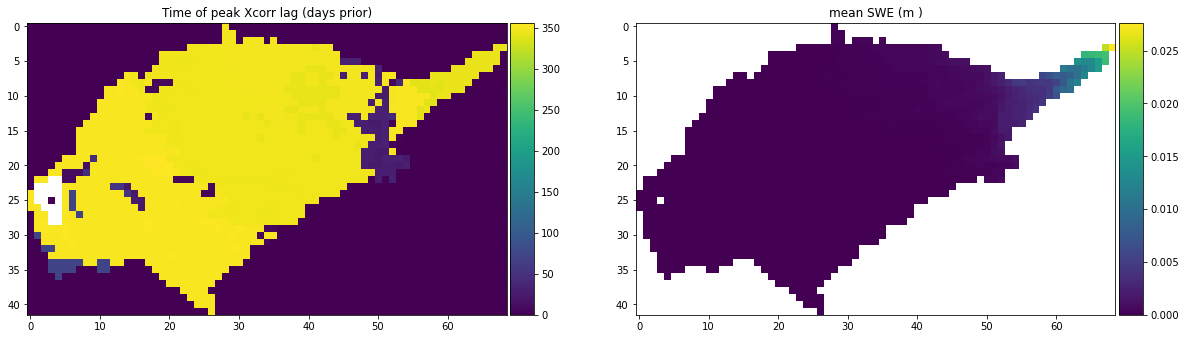

14
************************************************************
SHA SACRAMENTO R
https://cdec.water.ca.gov/dynamicapp/req/CSVDataServlet?Stations=SHA&SensorNums=76&dur_code=D&Start=2000-01-01&End=2020-01-01


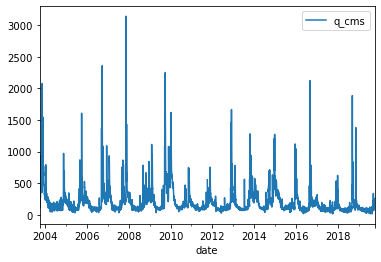

100%|██████████| 6210/6210 [17:17<00:00,  5.98it/s] 


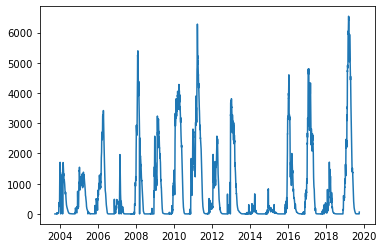

Running Xcorr...
wrote ../rasters/SHA_lag.tif


<ipython-input-31-551c937acae8>:88: RuntimeWarning: Mean of empty slice
  im2 = ax2.imshow(np.nanmean(swestack, axis = 2))


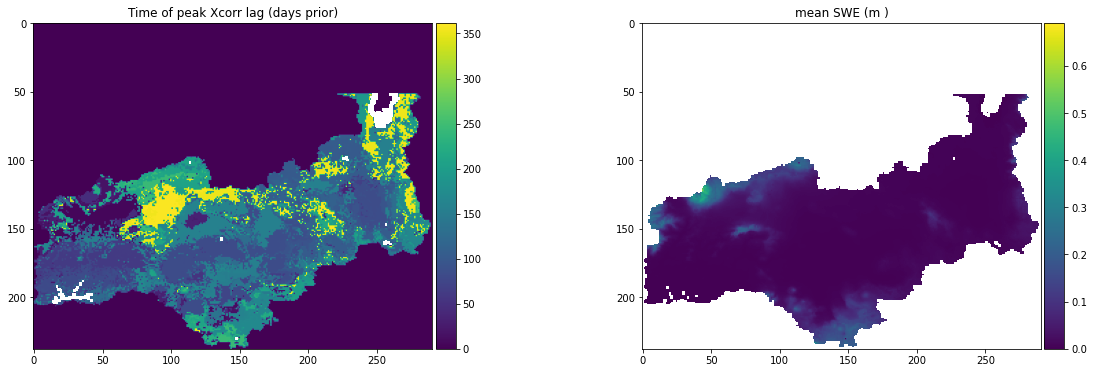

In [31]:
for idx, x in enumerate(gdf[:].iterrows()):
    print(idx)
    print("****" * 15)

    row  = x[1]
    stn_id = row['stid']
    print(stn_id, row['catch_name'])
    
    # Get the daily reservoir inflow
    try:
        outflow = get_res_inflow(stn_id, startdate, enddate)
        outflow.plot()
        plt.show()
    except:
        print("no data for {}".format(stn_id))
        continue
        
    # Get the SWE
    catch_shp = "../shape/{}.shp".format(stn_id)
    swe = get_snodas_swe(catch_shp, startdate, enddate)
    swestack = np.dstack(list(swe.values()))
    dswe = np.diff(swestack, axis = 2)
    plt.plot(dt_idx, [np.nansum(x) for x in swe.values()])
    plt.show()
    
    # Format for pxlwise xcorr 
    print("Running Xcorr...")
    
    rows, cols, time = swestack.shape
    px_ts = []
    rclist = []
    
    # extract pixelwise timeseries
    for row in range(rows):
        for col in range(cols):
            ts_arr = dswe[row,col,:]
            if not np.isnan(ts_arr).all():

                px_ts.append(ts_arr)
                rclist.append([row,col])

    pxdf = pd.DataFrame(px_ts).T
    
    # Merge the dfs
    pxdf.index = dt_idx[1:]
    mdf = pd.merge(outflow, pxdf, left_index = True, right_index = True)

    # Compute the cross corr 
    target = 'q_cms'
    df_new = df_shifted(mdf, target, lag=-1)
    lagged_correlation = pd.DataFrame.from_dict(
    {x: [df_new[target].corr(df_new[x].shift(-t)) for t in range(365)] for x in df_new.columns})

    # Drop the target 
    lagged_correlation.drop(['q_cms'], axis =1 , inplace = True)
    # Find the indices of max xcorr
    lagdf = pd.DataFrame(lagged_correlation.abs().idxmax(axis=0)).T

    # Build the out image
    lagim = np.zeros_like(np.mean(swestack, axis = 2))

    # Populate the per-pixel lags 
    for rc, dfcolidx in zip(rclist,lagdf.columns):

        rowidx, colidx = rc
        val = lagdf[dfcolidx].values[0]
        lagim[rowidx,colidx] = val

    
    # Compute mean swe and write
    meanswe = np.nanmean(swestack, axis = 2)
    rs.write_raster(meanswe, gp.read_file(catch_shp), '../rasters/{}_swe.tif'.format(stn_id) )
    
    # Apply the mask from the swe data 
    lagim = np.where(meanswe==np.nan,meanswe,lagim)
    
    # Write lag im 
    rs.write_raster(lagim, gp.read_file(catch_shp), '../rasters/{}_lag.tif'.format(stn_id) )
    
    # Plot lag images 
    plt.figure(figsize = (20, 6))
    plt.subplot(1,2,1)

    ax = plt.gca()
    im1 = ax.imshow(lagim)

    # create cax for cbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    plt.colorbar(im1, cax=cax)
    ax.set_title("Time of peak Xcorr lag (days prior)")

    plt.subplot(1,2,2)
    ax2 = plt.gca()
    im2 = ax2.imshow(meanswe)

    # create cax for cbar
    divider2 = make_axes_locatable(ax2)
    cax2 = divider2.append_axes("right", size="5%", pad=0.05)

    plt.colorbar(im2, cax=cax2)
    ax2.set_title("mean SWE (m )")

    plt.show()


In [71]:
lagim[lagim==0] = np.nan

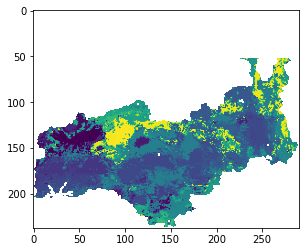

In [77]:
plt.imshow(np.where(meanswe==np.nan,meanswe,lagim))


In [64]:
meanswe = np.nanmean(swestack, axis = 2)


<ipython-input-64-1f46be7316ef>:1: RuntimeWarning: Mean of empty slice
  meanswe = np.nanmean(swestack, axis = 2)


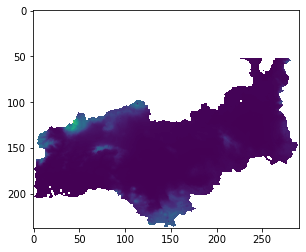

In [65]:
plt.imshow(meanswe)

In [70]:
meanswe[np.isnan(meanswe)].reshape(meanswe.shape)

ValueError: cannot reshape array of size 42458 into shape (238,291)

In [47]:
m = np.ma.masked_where(meanswe == np.nan, meanswe)  

In [48]:
l = lagim[~m.mask].copy()

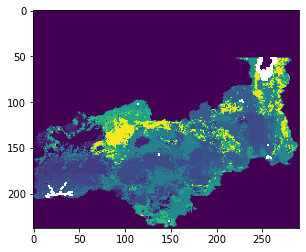

In [56]:
plt.imshow(l.reshape(l.shape[1],l.shape[2]))

In [39]:
new_lag = np.ma.masked_where(np.ma.getmask(m), lagim) # applies the mask of m on x


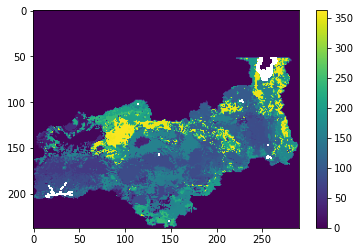

In [41]:
plt.imshow(new_lag)
plt.colorbar()

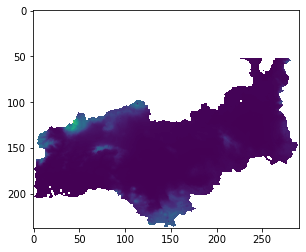

In [43]:
plt.imshow(m)

In [79]:
# Clip the rasters to the watershed boundaries 

for idx, x in enumerate(gdf[:].iterrows()):
    print(idx)
    print("****" * 15)

    row  = x[1]
    stn_id = row['stid']
    print(stn_id, row['catch_name'])
        
    # Clip rasters to shp 
    catch_shp = "../shape/{}.shp".format(stn_id)
    
    cmd = '''gdalwarp -cutline {} -crop_to_cutline -dstalpha ../rasters/{}_lag.tif ../rasters/{}_lag_cl.tif'''.format(catch_shp, stn_id, stn_id)
    print(cmd)
    os.system(cmd) 


0
************************************************************
ENG YUBA R
gdalwarp -cutline ../shape/ENG.shp -crop_to_cutline -dstalpha ../rasters/ENG_lag.tif ../rasters/ENG_lag_cl.tif
1
************************************************************
PAR MOKELUMNE R
gdalwarp -cutline ../shape/PAR.shp -crop_to_cutline -dstalpha ../rasters/PAR_lag.tif ../rasters/PAR_lag_cl.tif
2
************************************************************
MIL SAN JOAQUIN R
gdalwarp -cutline ../shape/MIL.shp -crop_to_cutline -dstalpha ../rasters/MIL_lag.tif ../rasters/MIL_lag_cl.tif
3
************************************************************
ISB KERN R
gdalwarp -cutline ../shape/ISB.shp -crop_to_cutline -dstalpha ../rasters/ISB_lag.tif ../rasters/ISB_lag_cl.tif
4
************************************************************
DNP TUOLUMNE R
gdalwarp -cutline ../shape/DNP.shp -crop_to_cutline -dstalpha ../rasters/DNP_lag.tif ../rasters/DNP_lag_cl.tif
5
*********************************************************

# Run the following to merge rasters:
```gdal_merge.py -n 0 -o snl.tif *cl.tif```
